In [9]:
import warnings
import datetime
from pandas import concat, set_option
from ffn import to_price_index
from yfinance import download
warnings.filterwarnings("ignore")

name = "Default Haa"
# Inputs
offensives = ['SPY','IWM','VEA','VWO','DBC','VNQ','IEF','TLT']
defensives = ['IEF', 'BIL']
protectives = ['TIP']
number_of_assets = 4
all_stocks = offensives + defensives + protectives
end_date=datetime.date.today()

delta=datetime.timedelta(days=500)
start_date=end_date-delta

In [22]:
for i in all_stocks:
    print(i, end=" ")

SPY IWM VEA VWO DBC VNQ IEF TLT IEF BIL TIP 

In [11]:
yahoo_data = download(
    all_stocks,
    start=start_date.strftime('%Y-%m-%d'),
    end=end_date.strftime('%Y-%m-%d')
    )['Adj Close'].pct_change().dropna()

[*********************100%%**********************]  10 of 10 completed


In [13]:
yahoo_data

Ticker,BIL,DBC,IEF,IWM,SPY,TIP,TLT,VEA,VNQ,VWO
Date,,,,,,,,,,
2022-09-27,100.032774,101.066107,99.317304,100.341107,99.744730,99.470790,97.366896,99.395758,98.668321,99.945950
2022-09-28,100.043687,103.880597,101.554461,103.514662,101.707347,101.228499,100.626931,101.620439,100.715166,100.729726
2022-09-29,100.065557,103.240937,101.081825,101.193900,99.582785,99.810991,100.106097,100.357046,97.755859,98.756758
2022-09-30,100.065557,101.961624,100.819242,100.456854,98.042876,99.130603,98.813655,99.862667,98.853266,98.621623
2022-10-03,100.038191,104.264394,102.015780,103.118733,100.631324,100.406349,100.383740,102.087325,100.616523,100.135135
...,...,...,...,...,...,...,...,...,...,...
2024-01-31,106.346144,100.506423,105.182521,119.788780,135.178900,105.228072,97.402745,136.044802,109.526856,112.826803
2024-02-01,106.399679,99.291162,105.834010,121.378675,136.948142,105.413455,99.313395,137.480480,111.511375,113.595301
2024-02-02,106.422961,98.165922,104.456700,120.738991,138.389847,104.398737,97.119687,136.504219,110.127431,112.798344


In [12]:
# print("\nRaw data:")
# print(yahoo_data[-10:])

# Overwrite yahoo data with a the stocks' price index
for column in yahoo_data.columns.to_list():
    yahoo_data[column] = yahoo_data[column].dropna().to_price_index()


# print("\nIndexed data:")
# print(yahoo_data[-5:])

data_monthly = yahoo_data.resample('BM').last()
# Replace last index date (which will be last day of the month) with today's date for clarity.
data_monthly.rename(index={data_monthly.index[-1]:datetime.datetime.today()},inplace=True)
data_monthly.index = data_monthly.index.strftime('%B %d, %Y')

# print("\nMonthly change %")
# print(data_monthly.pct_change().dropna()[-5:])

# Calculate momentum score
score = sum([(data_monthly / data_monthly.shift(m) - 1) / 4 for m in [1,3,6,12]]).dropna()
of_score = score[offensives]
def_score = score[defensives]
prot_score = score[protectives]

set_option('display.max_columns', None)

print("\nMomentum scores:")
print(score[-5:])

# Calculate if there's absolute momentum (If protectives, TIP, have positive a positive momentum score)
absolute_momentum = score.apply(lambda x: True if min(x[protectives]) > 0 else False, axis=1).to_frame('absolute_momentum')

# print("")
# print(absolute_momentum[-5:])

def pick_4_best_assets(x):
    if x['absolute_momentum']:
        of_momentums = x[offensives].astype(float).sort_values(ascending=False).iloc[:number_of_assets]
        def_momentum = x[defensives].astype(float).sort_values(ascending=False).iloc[:1]
        pos_of_momentums = of_momentums.loc[lambda x: x > 0]
        # print(pos_of_momentums)
        a = len(pos_of_momentums)
        while a < number_of_assets:
            a += 1
            pos_of_momentums = concat([pos_of_momentums, def_momentum], axis=0)
        return pos_of_momentums.index.to_list()
    else:
        return x[defensives].astype(float).idxmax()


prediction = score.join(absolute_momentum).apply(pick_4_best_assets, axis=1).dropna()

print("\nPredictions for month after:")
print(prediction[:])

print("\nThe allocation for {} is {}. The Hybrid Asset Allocation".format(datetime.datetime.today().strftime('%B %Y'), prediction[-2:].to_list()[0]))
print("strategy dictates to (re)allocate on the first trading day of the month.\n")


Momentum scores:
Ticker                  BIL       DBC       IEF       IWM       SPY       TIP  \
Date                                                                            
October 31, 2023   0.022641 -0.000747 -0.047364 -0.094906  0.001916 -0.024790   
November 30, 2023  0.023300 -0.006025 -0.002530  0.016181  0.086416  0.004559   
December 29, 2023  0.023355 -0.037454  0.038677  0.127518  0.126053  0.031208   
January 31, 2024   0.023819 -0.034946  0.027929  0.034695  0.111025  0.025061   
February 07, 2024  0.020357 -0.035723  0.014712  0.041492  0.120120  0.012342   

Ticker                  TLT       VEA       VNQ       VWO  
Date                                                       
October 31, 2023  -0.128962 -0.021257 -0.089900 -0.021312  
November 30, 2023 -0.029634  0.059616  0.034083  0.042487  
December 29, 2023  0.056335  0.100808  0.119032  0.059280  
January 31, 2024   0.015770  0.052536  0.020417 -0.011939  
February 07, 2024  0.001208  0.055417  0.023005  0.038

In [14]:
from financetoolkit import Toolkit

API_KEY = "jTWSv7sh7FNegFC17I38aFSDSrmLOucH"

In [15]:
# Initialize the Toolkit with company tickers
companies = Toolkit(
    ["AAPL", "MSFT", "GOOGL", "AMZN"], api_key=API_KEY, start_date="2005-01-01"
)

Obtaining historical data: 100%|██████████| 5/5 [00:00<00:00,  9.81it/s]


Open                                   High                \
              AAPL   MSFT  GOOGL   AMZN Benchmark    AAPL   MSFT  GOOGL   
date                                                                      
2005-01-03    1.16   26.8   4.94   2.25    121.56    1.16  26.95    5.1   
2005-01-04    1.14  26.87   5.04   2.13    120.46    1.17   27.1   5.08   
2005-01-05    1.15  26.84   4.84   2.08    118.74    1.17   27.1   4.93   
2005-01-06    1.15  26.85   4.88   2.09    118.44    1.16  27.06    4.9   
2005-01-07    1.16  26.82   4.77   2.07    118.97    1.24  26.89   4.86   
...            ...    ...    ...    ...       ...     ...    ...    ...   
2024-01-31  187.04 406.96 143.62  157.0    488.62 187.095 415.32  144.0   
2024-02-01 183.985 401.83 142.12 155.87    484.63  186.95  408.0 143.06   
2024-02-02  179.86 403.81 139.26 169.19    489.65  187.33 412.65 142.62   
2024-02-05  188.15  409.9 142.82  170.2   493.695  189.25 411.16 145.47   
2024-02-06  186.86 405.88 144.65 169.39    493.52  189.31 407.97 145.36   

                                 Low                                 Close  \
             AMZN Benchmark     AAPL   MSFT  GOOGL   AMZN Benchmark   AAPL   
date                                                                         
2005-01-03   2.27    121.76     1.12  26.65   4.89   2.21     119.9   1.13   
2005-01-04   2.16    120.54     1.12  26.66   4.84   2.08    118.44   1.14   
2005-01-05   2.14    119.25     1.14  26.76   4.81   2.08     118.0   1.15   
2005-01-06   2.11    119.15     1.13  26.64    4.7   2.05    118.26   1.15   
2005-01-07   2.13    119.23     1.16  26.62   4.72   2.06    118.13   1.24   
...           ...       ...      ...    ...    ...    ...       ...    ...   
2024-01-31 159.01  489.0813   184.35 397.21 139.87 154.81    482.86  184.4   
2024-02-01 159.76    489.23   183.82  401.8 140.79 155.62     483.8 186.86   
2024-02-02  172.5    496.05   179.25 403.56  136.5 167.33     489.3 185.85   
2024-02-05 170.55  494.3778   185.84 403.99 142.78  167.7    490.23 187.68   
2024-02-06 170.71    494.32 186.7695 402.91 143.19 167.65    492.05  189.3   

                                          Adj Close                       \
             MSFT  GOOGL   AMZN Benchmark      AAPL   MSFT  GOOGL   AMZN   
date                                                                       
2005-01-03  26.74   5.07   2.23     120.3     0.958   18.7   5.07   2.23   
2005-01-04  26.84   4.87   2.11    118.83    0.9679  18.76   4.87   2.11   
2005-01-05  26.78   4.84   2.09    118.01    0.9764  18.72   4.84   2.09   
2005-01-06  26.75   4.72   2.05    118.61    0.9771   18.7   4.72   2.05   
2005-01-07  26.67   4.85   2.12    118.44      1.05  18.65   4.85   2.12   
...           ...    ...    ...       ...       ...    ...    ...    ...   
2024-01-31 397.58  140.1  155.2    482.88     184.4 397.58  140.1  155.2   
2024-02-01 403.78 141.16 159.28     489.2    186.86 403.78 141.16 159.28   
2024-02-02 411.22 142.38 171.81    494.35    185.85 411.22 142.38 171.81   
2024-02-05 405.65 143.68 170.31    492.55    187.68 405.65 143.68 170.31   
2024-02-06 405.49  144.1 169.15    493.98     189.3 405.49  144.1 169.15   

                           Volume                                      \
           Benchmark         AAPL        MSFT       GOOGL        AMZN   
date                                                                    
2005-01-03     83.62  691992000.0  65002900.0 633134232.0 208930000.0   
2005-01-04      82.6 1096810400.0 109442100.0 549685764.0 388370000.0   
2005-01-05     82.03  680433600.0  72463500.0 329134536.0 167084000.0   
2005-01-06     82.45  705555200.0  76890500.0 415068516.0 174018000.0   
2005-01-07     82.33 2227450400.0  68723300.0 386129484.0 196732000.0   
...              ...          ...         ...         ...         ...   
2024-01-31    482.88   55467803.0  47855797.0  71889544.0  50155866.0   
2024-02-01     489.2   64885408.0  30656726.0  40466549.0  76222119.0   
20

Open                                  High                       \
       AAPL   MSFT  GOOGL   AMZN Benchmark   AAPL   MSFT  GOOGL   AMZN   
Date                                                                     
2005   2.53  26.15  10.44   2.39     124.8   2.59  26.31  10.47   2.41   
2006    3.0  29.86  11.56    2.0    142.06   3.05  30.15  11.62   2.01   
2007   7.13   35.9  17.48   4.69     147.1   7.16  35.99  17.58   4.72   
2008   3.07  19.31   7.61   2.54     89.08   3.13  19.68   7.78   2.58   
2009   7.61  30.98  15.63   6.85    112.77   7.62  30.99  15.65   6.86   
2010  11.53   27.8  14.93    9.1    125.53  11.55  27.92  14.98   9.12   
2011  14.41   26.0  16.07   8.67    126.02  14.51  26.12  16.19   8.76   
2012  18.23  26.59  17.52  12.19    139.66  19.12  26.77  17.78  12.62   
2013  19.79   37.4  27.83  19.73    184.07  20.05  37.58  28.05  19.94   
2014  28.21  46.73  26.89  15.58    207.99  28.28  47.44  26.92  15.65   
2015  26.75  56.04  39.39   34.3    205.13  26.76  56.19  39.42  34.39   
2016  29.16  62.96  40.16  38.32    224.73   29.3  62.99  40.16  38.37   
2017  42.63  85.63  52.77  59.12    268.53  42.65  86.05   52.9   59.2   
2018  39.63 101.29  52.89  75.54    249.56  39.84  102.4  53.15  76.04   
2019  72.48 156.77  66.79   92.1    320.53  73.42 157.77  67.03  92.66   
2020 134.08  221.7  86.86 163.75    371.78 134.74  223.0  87.88 164.15   
2021 178.09 338.51 146.05 168.96    475.64 179.23 339.36  146.7 169.35   
2022 128.41 238.21  86.98  83.12    380.64 129.95 239.96   88.3  84.05   
2023  193.9  376.0 139.63  153.1    476.49  194.4 377.16 140.36 153.89   
2024 186.86 405.88 144.65 169.39    493.52 189.31 407.97 145.36 170.71   

                    Low                                 Close                \
     Benchmark     AAPL   MSFT  GOOGL   AMZN Benchmark   AAPL   MSFT  GOOGL   
Date                                                                          
2005    125.06     2.51   26.1  10.35   2.36    124.36   2.57  26.15  10.38   
2006    142.54     2.98  29.83  11.51   1.97    141.43   3.03  29.86  11.52   
2007    147.61     7.06  35.52  17.28   4.62    146.06   7.07   35.6   17.3   
2008     90.97     3.05  19.27   7.57    2.5     88.87   3.05  19.44    7.7   
2009     112.8     7.52  30.48  15.52   6.73    111.39   7.53  30.48  15.52   
2010    125.87    11.48  27.63  14.82   8.98    125.33  11.52  27.91  14.86   
2011    126.33    14.41  25.91  16.07   8.62     125.5  14.46  25.96  16.16   
2012    142.56    18.18  26.37  17.42  12.14    139.54  19.01  26.71   17.7   
2013    184.69    19.79  37.22  27.68  19.69    183.93  20.04  37.41  28.05   
2014    208.19    27.55  46.45  26.51   15.5    205.39  27.59  46.45  26.53   
2015    205.89    26.21  55.42  38.87  33.79    203.87  26.32  55.48   38.9   
2016    224.83    28.86  62.03  39.48  37.41    222.73  28.96  62.14  39.62   
2017    268.55    42.31   85.5  52.63  58.38    266.64  42.31  85.54  52.67   
2018    250.19    39.12 100.44  51.65  74.35    247.47  39.44 101.57  52.25   
2019    322.13    72.38 156.45  66.61  91.61    320.15  73.41  157.7  66.97   
2020    374.66   131.72 219.68   86.8 162.06    371.23 132.69 222.42  87.63   
2021    476.86   177.26 335.85 144.85 166.56    474.67 177.57 336.32 144.85   
2022    382.58   127.43 236.66  86.57  82.47    378.43 129.93 239.82  88.23   
2023    477.03  191.725 373.48 138.78 151.03     473.3 192.53 376.04 139.69   
2024    494.32 186.7695 402.91 143.19 167.65    492.05  189.3 405.49  144.1   

                      Adj Close                                      Volume  \
       AMZN Benchmark      AAPL   MSFT  GOOGL   AMZN Benchmark         AAPL   
Date                                                                          
2005   2.36    124.51      2.18  18.51  10.38   2.36     88.08  624262800.0   
2006   1.97    141.62      2.57  21.44  11.52   1.97    102.03 1076429200.0   
2007   4.63    146.21       6.0  25.91   17.3   4.63    107.28  539333200.0   
2008   2.56 

<Axes: title={'center': 'Cumulative Returns of Apple, Microsoft, Google and Amazon'}, xlabel='Date', ylabel='Cumulative Return'>

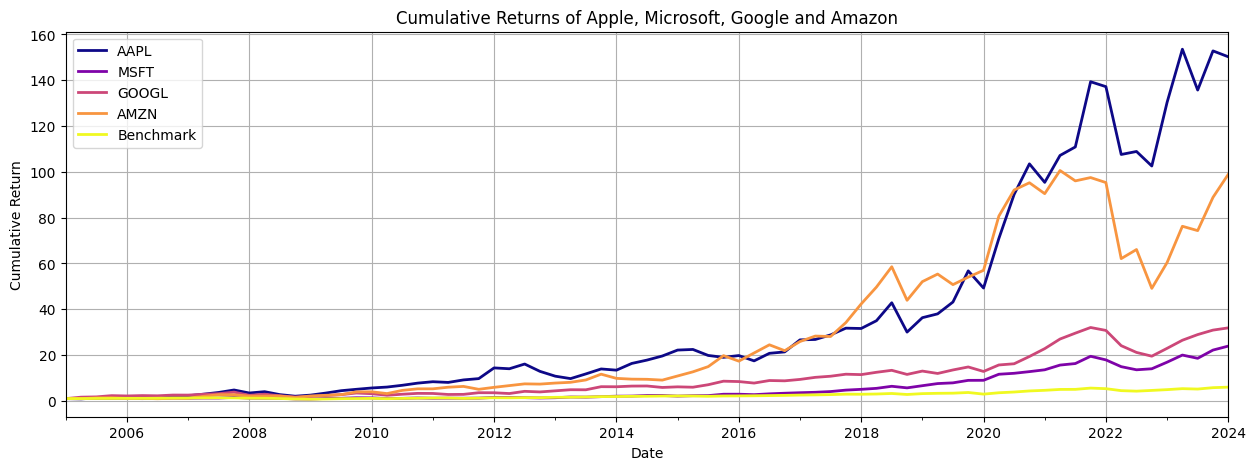

In [16]:
# Obtain daily historical data from each company
display(companies.get_historical_data())

# Obtain yearly historical data from each company
display(companies.get_historical_data(period="yearly"))

# Plot the Cumulative Returns
companies.get_historical_data(period="quarterly")["Cumulative Return"].plot(
    figsize=(15, 5),
    title="Cumulative Returns of Apple, Microsoft, Google and Amazon",
    grid=True,
    linestyle="-",
    linewidth=2,
    colormap="plasma",
    xlabel="Date",
    ylabel="Cumulative Return",
)

In [17]:
companies.get_historical_statistics()

Obtaining historical statistics: 100%|██████████| 4/4 [00:00<00:00,  9.80it/s]


,AAPL,MSFT,GOOGL,AMZN
Currency,USD,USD,USD,USD
Symbol,AAPL,MSFT,GOOGL,AMZN
Exchange Name,NMS,NMS,NMS,NMS
Instrument Type,EQUITY,EQUITY,EQUITY,EQUITY
First Trade Date,1980-12-12,1986-03-13,2004-08-19,1997-05-15
Regular Market Time,2024-02-07,2024-02-07,2024-02-07,2024-02-07
GMT Offset,-18000,-18000,-18000,-18000
Timezone,EST,EST,EST,EST
Exchange Timezone Name,America/New_York,America/New_York,America/New_York,America/New_York
